```{index} single: application; production planning
```
```{index} single: solver; cbc
```
```{index} single: solver; highs
```
```{index} pandas dataframe
```
```{index} single: Pyomo; parameters
```
```{index} single: Pyomo; sets
```
```{index} single: Pyomo; expressions
```
```{index} simulations
```

# Robustness analysis of BIM production plan via simulations

This example is a continuation of the BIM chip production problem illustrated [here](../02/bim.ipynb). Recall hat BIM produces logic and memory chips using copper, silicon, germanium, and plastic and that each chip requires the following quantities of raw materials:

| chip   | copper | silicon | germanium | plastic |
|:-------|-------:|--------:|----------:|--------:|
|logic   |    0.4 |       1 |         - |       1 |
|memory  |    0.2 |       - |         1 |       1 |

BIM needs to carefully manage the acquisition and inventory of these raw materials based on the forecasted demand for the chips. Data analysis led to the following prediction of monthly demands:

| chip   | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:-------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|logic   |  88 | 125 | 260 | 217 | 238 | 286 | 248 | 238 | 265 | 293 | 259 | 244 |
|memory  |  47 |  62 |  81 |  65 |  95 | 118 |  86 |  89 |  82 |  82 |  84 | 66  |

At the beginning of the year, BIM has the following stock:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   480|  1000 |     1500|  1750 |

The company would like to have at least the following stock at the end of the year:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   200|   500 |      500|  1000 |

Each raw material can be acquired at each month, but the unit prices vary as follows:

| product  | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:---------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|copper    |   1 |   1 |   1 |   2 |   2 |   3 |   3 |   2 |   2 |   1 |   1 |   2 |
|silicon   |   4 |   3 |   3 |   3 |   5 |   5 |   6 |   5 |   4 |   3 |   3 |   5 |
|germanium |   5 |   5 |   5 |   3 |   3 |   3 |   3 |   2 |   3 |   4 |   5 |   6 |
|plastic   | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 |

The inventory is limited by a capacity of a total of 9000 units per month, regardless of the type of material of products in stock. The holding costs of the inventory are 0.05 per unit per month regardless of the material type. Due to budget constraints, BIM cannot spend more than 5000 per month on acquisition.

BIM aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. The production is made to order, meaning that no inventory of chips is kept.

Let us model the material acquisition planning and solve it optimally based on the forecasted chip demand above.

In [1]:
# install dependencies and select solver
!pip install -q amplpy numpy pandas matplotlib

SOLVER = "cbc"    ## highs, scip, cbc, mosek, gurobi, cplex, xpress, knitro

In [2]:
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["coin", "highs"],  # modules to install
    license_uuid="default"      # license to use
) # instantiate AMPL object and register notebook magics

Please provide a valid license UUID. You can use a free https://ampl.com/ce license.


In [3]:
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

demand_data = '''
chip, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
logic, 88, 125, 260, 217, 238, 286, 248, 238, 265, 293, 259, 244
memory, 47, 62, 81, 65, 95, 118, 86, 89, 82, 82, 84, 66
'''

demand_chips = pd.read_csv(StringIO(demand_data), index_col='chip')
display(demand_chips)

price_data = '''
product, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
copper, 1, 1, 1, 2, 2, 3, 3, 2, 2, 1, 1, 2
silicon, 4, 3, 3, 3, 5, 5, 6, 5, 4, 3, 3, 5
germanium, 5, 5, 5, 3, 3, 3, 3, 2, 3, 4, 5, 6
plastic, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
'''

price = pd.read_csv(StringIO(price_data), index_col='product')
display(price)

use = dict()
use['logic'] = {'silicon': 1, 'plastic': 1, 'copper': 4}
use['memory'] = {'germanium': 1, 'plastic': 1, 'copper': 2}
use = pd.DataFrame.from_dict(use).fillna(0).astype(int)
material_demand = use.dot(demand_chips)

existing = pd.Series({'silicon': 1000, 'germanium': 1500, 'plastic': 1750, 'copper': 4800 })
eot_inventory = pd.Series({'silicon':  500, 'germanium':  500, 'plastic': 1000, 'copper': 2000 })

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
logic,88,125,260,217,238,286,248,238,265,293,259,244
memory,47,62,81,65,95,118,86,89,82,82,84,66


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product,,,,,,,,,,,,
copper,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0
silicon,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,4.0,3.0,3.0,5.0
germanium,5.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,6.0
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [4]:
# we store all the problem data in one object to easily perform folding-horizon simulations
def initialize_problem_data():
    problem_data = {
        "price": price.copy(deep=True),
        "inventory_cost": 0.05,
        "material_demand": material_demand.copy(deep=True),
        "demand_chips_ref": demand_chips.copy(deep=True),
        "demand_chips_simulation": demand_chips.copy(deep=True),
        "use": use.copy(deep=True),
        "existing": existing.copy(deep=True),
        "eot_inventory": eot_inventory.copy(deep=True),
        "stock_limit": 9000,
        "month_budget": 2500
    }
    return problem_data

def ShowTable( X, I, J ):
    return pd.DataFrame.from_records( [ [ X[i,j] for j in J ] for i in I ], index=I, columns=J ).round(decimals = 2)

In [5]:
%%writefile product_inventory.mod

set PERIODS;
set PRODUCTS;

param first symbolic;
param prev_period{PERIODS} symbolic;
param last symbolic;

param stock_limit;
param month_budget;

param pi{PERIODS, PRODUCTS};        # acquisition price
param h{PERIODS, PRODUCTS};         # holding cost
param delta{PERIODS, PRODUCTS};     # demand

param existing{PRODUCTS};
param desired{PRODUCTS};

var x{PERIODS, PRODUCTS} >= 0;
var s{PERIODS, PRODUCTS} >= 0;

var acquisition_cost
    = sum {t in PERIODS, p in PRODUCTS} pi[t,p] * x[t,p];
    
var inventory_cost
    = sum {t in PERIODS, p in PRODUCTS} h[t,p] * s[t,p];
    
minimize TotalCost: acquisition_cost + inventory_cost;
    
s.t. Balance{t in PERIODS, p in PRODUCTS}:
    (if t==first then existing[p] else s[prev_period[t],p])
        + x[t,p] == delta[t,p] + s[t,p];
        
s.t. Finish{p in PRODUCTS}:
    s[last,p] >= desired[p];
    
s.t. Inventory{t in PERIODS}:
    sum {p in PRODUCTS} s[t,p] <= stock_limit;
    
s.t. Budget{t in PERIODS}:
    sum {p in PRODUCTS} pi[t,p]*x[t,p] <= month_budget;


Overwriting product_inventory.mod


In [6]:
def BIMProductAcquisitionAndInventory(problem_data):
    
    demand = problem_data["use"].dot( problem_data["demand_chips_ref"] )
    acquisition_price = problem_data["price"]
    existing = problem_data["existing"]
    desired = problem_data["eot_inventory"]
    stock_limit = problem_data["stock_limit"]
    month_budget = problem_data["month_budget"]
    
    ampl = AMPL()
    ampl.read("product_inventory.mod")

    periods = list(demand.columns)
    products = list(demand.index)
    
    ampl.set["PERIODS"]  = periods
    ampl.set["PRODUCTS"] = products
    ampl.param["first"]  = periods[0] 
    ampl.param["prev_period"] \
        = { j : i for i,j in zip(periods,periods[1:]) }
    ampl.param["last"]   = periods[-1]
    
    ampl.param["stock_limit"] = stock_limit;
    ampl.param["month_budget"] = month_budget;
    
    ampl.param["pi"] = acquisition_price.unstack()
    ampl.param["h"] = {
        (t, p): .05
        for p in products
        for t in periods
    }
    ampl.param["delta"] = demand.unstack()

    ampl.param["existing"] = existing
    ampl.param["desired"] = desired

    ampl.option["solver"] = SOLVER
    ampl.solve()

    return ampl, products, periods

problem_data = initialize_problem_data()
m, products, periods = BIMProductAcquisitionAndInventory(problem_data)

print(f"The optimal solution yields a total cost of {m.get_value('TotalCost'):.2f}\n")

x = m.get_variable('x').get_values().to_dict()
#x.index = pd.MultiIndex.from_tuples(x.index)
problem_data["purchases"] = ShowTable(x, periods, products).T

s = m.get_variable('s').get_values().to_dict()
problem_data["stock"] = ShowTable(s, periods, products).T

display(problem_data["purchases"])
display(problem_data["stock"])

cbc 2.10.7: cbc 2.10.7: optimal solution; objective 23580.34083
0 simplex iterations

"option abs_boundtol 1.1368683772161603e-13;"
or "option rel_boundtol 2.2737367544323206e-16;"
will change deduced dual values.

The optimal solution yields a total cost of 23580.34



,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,0.00,833.33,0.0,833.33,0.00,0.0,0.0,0.00,594.33,0.0,0.0,0.0
plastic,0.00,0.00,0.0,0.00,0.00,0.0,266.0,327.00,722.00,0.0,343.0,1310.0
copper,214.67,0.00,2500.0,0.00,536.45,0.0,0.0,1233.65,25.23,2500.0,2465.7,682.3
germanium,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912.00,1620.33,1360.33,1976.67,1738.67,1452.67,1204.67,966.67,1296.0,1003.0,744.0,500.0
plastic,1615.00,1428.00,1087.00,805.00,472.00,68.00,0.00,0.00,375.0,0.0,0.0,1000.0
copper,4568.67,3944.67,5242.67,4244.67,3639.12,2259.12,1095.12,1198.77,0.0,1164.0,2425.7,2000.0
germanium,1453.00,1391.00,1310.00,1245.00,1150.00,1032.00,946.00,857.00,775.0,693.0,609.0,543.0


## Actual performance of the robust solution

We now perform a stochastic simulation to assess the performance of the robust solutions that we found earlier.

In [7]:
%%writefile product_demand_missed_in_period.mod

set PRODUCTS;
set MATERIALS;

param avail{MATERIALS};
param use{MATERIALS, PRODUCTS};
param demand_chips{PRODUCTS};

# Decision variable: nb of chips to produce >= 0
var x{PRODUCTS} >= 0;

# Decision variable: missed demand
var s{PRODUCTS} >= 0;
    
# Constraint: per resource we cannot use more than there is
s.t. ResourceConstraint{i in MATERIALS}:
    sum {p in PRODUCTS} x[p] * use[i, p] <= avail[i];
    
# Constraint: production + missed demand = total demand in this period
s.t. ProducedPlusUnmet{p in PRODUCTS}:
    x[p] + s[p] == demand_chips[p];
    
# Objective - minimize the missed demand
minimize TotalUnmet:
        sum {p in PRODUCTS} s[p];


Overwriting product_demand_missed_in_period.mod


In [8]:
def minimize_missed_demand_in_period(inventory, missed_demand, purchases, existing, demand_chips, use, period = None):
    
    periods  = inventory.columns
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    ampl = AMPL()
    ampl.read("product_demand_missed_in_period.mod")

    products = list(use.columns)
    materials = list(use.index)
    
    ampl.set["PRODUCTS"] = products
    ampl.set["MATERIALS"]  = materials
    
    ampl.param["avail"] = {
        i: inventory.loc[i, prev[period]] + purchases.loc[i, period]
        for i in materials
    }
    ampl.param["use"] = {
        (i,p): use.at[i,p] for i in materials for p in products
    }
    ampl.param["demand_chips"] = demand_chips.loc[:, period]

    ampl.option["solver"] = SOLVER
    ampl.solve()

    x = ampl.get_variable('x').get_values().to_dict()
    s = ampl.get_variable('s').get_values().to_dict()

    # update inventory
    for i in materials:
        inventory.loc[i, period] = inventory.loc[i, prev[period]] + purchases.loc[i, period] \
                - sum([x[p] * use.loc[i, p] for p in products])
    
    # update missed demand
    for p in products:
        missed_demand.loc[p, period] = s[p]
    
    return 0

def simulation_per_trajectory(purchases, existing, demand_chips, use):
    
    # Set up the table to store inventory evolution
    inventory = pd.DataFrame(index = purchases.index, columns = purchases.columns)
    inventory = pd.concat([pd.DataFrame(existing, index = existing.index, columns = ["existing"]), inventory], axis = 1)
    
    # Set up the DF to store missed demand information
    missed_demand = pd.DataFrame(np.zeros((len(demand_chips.index), len(purchases.columns))), index = demand_chips.index, columns = purchases.columns)
    
    # Proper simulation
    for period in inventory.columns[1:]:
        minimize_missed_demand_in_period(inventory, missed_demand, purchases, existing, demand_chips, use, period)

    return inventory.iloc[:, 1:], missed_demand

def simulate_performance(problem_data, n = 50, rho = 0.05, seed = 0):
    
    rng = np.random.default_rng(seed)
    
    results = []
    for i in range(n):
        perturbed_demand = problem_data["demand_chips_simulation"].applymap(lambda x: x * (1 + rho * (1 - 2 * rng.random())))
        inv, md = simulation_per_trajectory(problem_data["purchases"], problem_data["existing"], perturbed_demand, use)
        results.append({"inventory": inv, "missing_demand": md})
        
    MissingDemand = pd.concat([i["missing_demand"] for i in results], keys = [i for i in range(len(results))])
    MissingDemand = MissingDemand.astype('float').swaplevel()
    
    InventoryEvolution = pd.concat([i["inventory"] for i in results], keys = [i for i in range(len(results))])
    InventoryEvolution = InventoryEvolution.astype('float').swaplevel()

    return {"MissingDemand": MissingDemand, "InventoryEvolution": InventoryEvolution}

def report(MissingDemand, InventoryEvolution, problem_data):
        
    # list to store DFs with per-group computed quantiles at various levels
    average_missed_demand = MissingDemand.groupby(level = 0).mean().transpose()

    # build a plot with as many subplots as there are chip types
    fig, axis = plt.subplots(figsize = (11, 4))
    average_missed_demand.plot(ax = axis, drawstyle='steps-mid',grid=True)
    plt.xticks(ticks = np.arange(len(average_missed_demand.index)), labels = average_missed_demand.index)
    # axis.set_title("Missed demand of chips under " + str(rho * 100) + "% uncertainty")
    fig.tight_layout(pad=3.0)
    plt.savefig("bim_robust_missed_demand.pdf")
    
    realized_inv_cost = InventoryEvolution.groupby(level = 0).mean().sum(axis = 1).sum() * problem_data["inventory_cost"]
    print(f'Purchasing cost: {(problem_data["price"] * problem_data["purchases"]).sum().sum():.2f}')
    print(f'Theoretical inventory cost: {(problem_data["stock"] * problem_data["inventory_cost"]).sum().sum():.2f}\n')
    print(f'Simulated realized inventory cost: {realized_inv_cost:.2f}')
    print(f'Simulated average missed demand for logic chips is {MissingDemand.groupby(level = 0).mean().sum(axis = 1)[0]:.3f} and for memory chips is {MissingDemand.groupby(level = 0).mean().sum(axis = 1)[1]:.3f}\n')
    print("Plot of missed chips demand over time under " + str(rho * 100) + "% uncertainty\n")
    plt.show()

We now simulate 50 trajectories assuming there is a $\rho=8\%$ uncertainty around the nominal demand.

In [9]:
rho = 0.08
N_sim = 50

problem_data["demand_chips_ref"] = demand_chips
m, products, periods = BIMProductAcquisitionAndInventory(problem_data)

x = m.get_variable('x').get_values().to_dict()
problem_data["purchases"] = ShowTable(x, periods, products).T
s = m.get_variable('s').get_values().to_dict()
problem_data["stock"] = ShowTable(s, periods, products).T

SimResults = simulate_performance(problem_data, N_sim, rho)

cbc 2.10.7cbc 2.10.7: optimal solution; objective 23580.34083
0 simplex iterations

"option abs_boundtol 1.1368683772161603e-13;"
or "option rel_boundtol 2.2737367544323206e-16;"
will change deduced dual values.

cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 sim

cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0

cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0.2895346977
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 16.82419217
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 3.98996927
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 14.58302638
0 simplex iterations
cbc 2.10.7c

cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 21.55840715
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; o

cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 36.74701521
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; o

cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0
0 simplex iterations
cbc 2.10.7cbc 2.10.7: optimal solution; objective 0

The simulation results report a sllighly higher inventory cost and a nonzero amount of missed chip demand.

Purchasing cost: 20309.73
Theoretical inventory cost: 3270.58

Simulated realized inventory cost: 3309.54
Simulated average missed demand for logic chips is 4.543 and for memory chips is 13.154

Plot of missed chips demand over time under 8.0% uncertainty



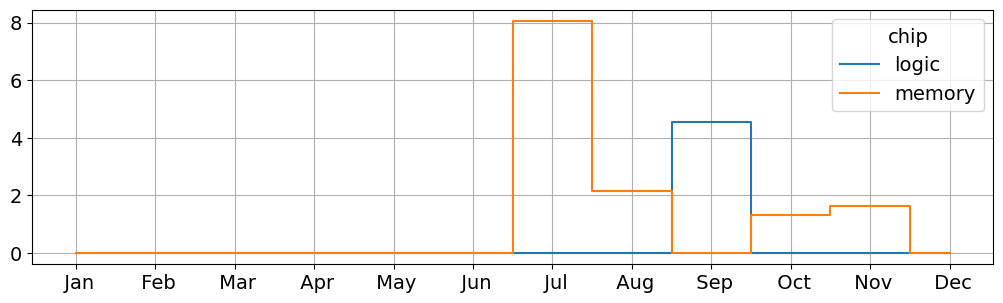

In [10]:
report(SimResults["MissingDemand"], SimResults["InventoryEvolution"], problem_data)